# Data science assessment - Fraud data

## objective
> to buld a machine learning model that predicts the probability that the first transaction of a new user is fraudulent

## details
- 'Electronica' : e-commerce site that sells wholesale electronics
- want to know a given transaction is fraudulent or not
- data of user's first transaction
- costs
    - fail to detect fraud : Electronica loses money equivalent to the price
    - false alert          : cost my client values 8$

In [1]:
# python built-in libraries
import os
from collections import Counter
from datetime import datetime, timedelta

# python third party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# setting
random_state = 79

## load data

In [2]:
directory = os.getcwd()
directory

'C:\\Users\\jhoonpark\\Desktop\\jhoonpark\\jhoonpark-codes\\detect_fraud_coding_test'

In [3]:
fraud_data = pd.read_csv(directory + '/dataset/df_final.csv', index_col=0)
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,purchase_time_date,time_to_purchase,purchase_value_max,purchase_value_min,purchase_value_avg,purchase_value_std,max_min_diff,user_id_count,country,device_id_ip_count_total
0,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,...,2015-09-10,57,40,31,35.5,6.363961,9,2,United States,2
1,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,...,2015-04-13,79,31,31,31.0,0.000000,0,1,United Kingdom,1
2,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,...,2015-04-05,25,16,16,16.0,0.000000,0,1,United States,1
3,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,...,2015-01-09,2,29,29,29.0,0.000000,0,1,Korea Republic of,1
4,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,...,2015-04-09,60,26,26,26.0,0.000000,0,1,Brazil,1


## preprocess

In [4]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120000 entries, 0 to 119999
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   user_id                   120000 non-null  int64  
 1   signup_time               120000 non-null  object 
 2   purchase_time             120000 non-null  object 
 3   purchase_value            120000 non-null  int64  
 4   device_id                 120000 non-null  object 
 5   source                    120000 non-null  object 
 6   browser                   120000 non-null  object 
 7   sex                       120000 non-null  object 
 8   age                       120000 non-null  int64  
 9   ip_address                120000 non-null  float64
 10  class                     120000 non-null  int64  
 11  signup_time_date          120000 non-null  object 
 12  purchase_time_date        120000 non-null  object 
 13  time_to_purchase          120000 non-null  i

#### make month for signup

In [5]:
fraud_data['signup_time_date'][0]

'2015-07-15'

In [6]:
type(fraud_data['signup_time_date'][0])

str

In [7]:
fraud_data['signup_time_date'][0].split('-')[1]

'07'

In [8]:
fraud_data['purchase_month'] = fraud_data['purchase_time_date'].map(lambda x : x.split('-')[1])
fraud_data['purchase_month']

0         09
1         04
2         04
3         01
4         04
          ..
119995    04
119996    08
119997    09
119998    06
119999    09
Name: purchase_month, Length: 120000, dtype: object

In [9]:
fraud_data['signup_month'] = fraud_data['signup_time_date'].map(lambda x : x.split('-')[1])
fraud_data['signup_month']

0         07
1         01
2         03
3         01
4         02
          ..
119995    02
119996    08
119997    07
119998    04
119999    07
Name: signup_month, Length: 120000, dtype: object

### make dummy data

In [10]:
gender_dummy         = pd.get_dummies(fraud_data.sex, drop_first = True)
signup_month_dummy   = pd.get_dummies(fraud_data.signup_month, drop_first = True, prefix = 'signup')
purchase_month_dummy = pd.get_dummies(fraud_data.purchase_month, drop_first = True, prefix = 'purchase')
source_dummy         = pd.get_dummies(fraud_data.source, drop_first = True)
browser_dummy        = pd.get_dummies(fraud_data.browser, drop_first = True)

fraud_data = fraud_data.drop(['sex','signup_month', 'purchase_month', 'source','browser'], axis=1)

final = pd.concat([fraud_data, gender_dummy, signup_month_dummy, purchase_month_dummy, source_dummy, browser_dummy], axis=1)
final.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,signup_time_date,purchase_time_date,...,purchase_09,purchase_10,purchase_11,purchase_12,Direct,SEO,FireFox,IE,Opera,Safari
0,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,49,2.818400e+09,0,2015-07-15,2015-09-10,...,1,0,0,0,1,0,0,0,0,0
1,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,21,3.251268e+09,0,2015-01-24,2015-04-13,...,0,0,0,0,0,1,0,1,0,0
2,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,26,2.727760e+09,0,2015-03-11,2015-04-05,...,0,0,0,0,1,0,0,1,0,0
3,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,34,2.083420e+09,0,2015-01-07,2015-01-09,...,0,0,0,0,0,1,0,0,0,0
4,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,33,3.207913e+09,0,2015-02-08,2015-04-09,...,0,0,0,0,0,0,1,0,0,0


## selected features
- date related features
    - signup_time_month dummy
    - purchase_time_month dummy
    - time_to_purchase
- purchase_value related features
    - group by device_id
    - purchase_value_{}
        - max, min, avg, std, max_min_diff
- user related feature
    - sex dummy
    - age
    - browser dummy
    - source dummy
    - the number of user_id connected to the device id

In [12]:
final.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'age', 'ip_address', 'class', 'signup_time_date',
       'purchase_time_date', 'time_to_purchase', 'purchase_value_max',
       'purchase_value_min', 'purchase_value_avg', 'purchase_value_std',
       'max_min_diff', 'user_id_count', 'country', 'device_id_ip_count_total',
       'M', 'signup_02', 'signup_03', 'signup_04', 'signup_05', 'signup_06',
       'signup_07', 'signup_08', 'purchase_02', 'purchase_03', 'purchase_04',
       'purchase_05', 'purchase_06', 'purchase_07', 'purchase_08',
       'purchase_09', 'purchase_10', 'purchase_11', 'purchase_12', 'Direct',
       'SEO', 'FireFox', 'IE', 'Opera', 'Safari'],
      dtype='object')

In [13]:
final = final.drop(['signup_time', 'purchase_time', 'device_id', 'ip_address', 'signup_time_date', 'purchase_time_date', 'country'], axis = 1)
final.columns

Index(['user_id', 'purchase_value', 'age', 'class', 'time_to_purchase',
       'purchase_value_max', 'purchase_value_min', 'purchase_value_avg',
       'purchase_value_std', 'max_min_diff', 'user_id_count',
       'device_id_ip_count_total', 'M', 'signup_02', 'signup_03', 'signup_04',
       'signup_05', 'signup_06', 'signup_07', 'signup_08', 'purchase_02',
       'purchase_03', 'purchase_04', 'purchase_05', 'purchase_06',
       'purchase_07', 'purchase_08', 'purchase_09', 'purchase_10',
       'purchase_11', 'purchase_12', 'Direct', 'SEO', 'FireFox', 'IE', 'Opera',
       'Safari'],
      dtype='object')

## deal with highly imbalanced data

- undesr sampling
    - can be balanced but lot of informations are lost
- over sampling
    - can be balanced but incorrect data could be input for learning
- In this questions...
    - **split class=0 data into 5 peaces to make 5 diffenrect dataset** with same class=1 data

In [14]:
final_0 = final.loc[final['class'] == 0,]
final_1 = final.loc[final['class'] == 1,]

In [15]:
final_0 = final_0.sample(frac=1).reset_index(drop=True)
final_0

,user_id,purchase_value,age,class,time_to_purchase,purchase_value_max,purchase_value_min,purchase_value_avg,purchase_value_std,max_min_diff,...,purchase_09,purchase_10,purchase_11,purchase_12,Direct,SEO,FireFox,IE,Opera,Safari
0,79863,26,39,0,91,26,26,26.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,17423,40,30,0,94,40,40,40.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,169447,52,35,0,59,52,52,52.0,0.0,0,...,0,0,0,0,0,1,0,1,0,0
3,209396,76,35,0,66,76,76,76.0,0.0,0,...,0,0,0,0,0,1,0,0,0,1
4,336312,22,27,0,31,22,22,22.0,0.0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108730,270900,28,33,0,3,28,28,28.0,0.0,0,...,0,0,0,0,1,0,0,1,0,0
108731,383037,62,36,0,94,62,62,62.0,0.0,0,...,0,0,0,0,0,1,0,0,0,0
108732,125158,24,21,0,92,24,24,24.0,0.0,0,...,0,0,0,0,0,1,0,0,0,0
108733,310126,40,49,0,3,40,40,40.0,0.0,0,...,0,0,0,0,1,0,0,0,0,0


In [16]:
flag = len(final_0)//5
flag

21747

In [17]:
final_0_1 = final_0.iloc[:flag,:]
final_0_2 = final_0.iloc[flag   : flag*2,:]
final_0_3 = final_0.iloc[flag*2 : flag*3,:]
final_0_4 = final_0.iloc[flag*3 : flag*4,:]
final_0_5 = final_0.iloc[flag*4 : :]

In [18]:
final__1 = pd.concat([final_0_1, final_1], axis=0).sample(frac=1).reset_index(drop=True)
final__2 = pd.concat([final_0_2, final_1], axis=0).sample(frac=1).reset_index(drop=True)
final__3 = pd.concat([final_0_3, final_1], axis=0).sample(frac=1).reset_index(drop=True)
final__4 = pd.concat([final_0_4, final_1], axis=0).sample(frac=1).reset_index(drop=True)
final__5 = pd.concat([final_0_5, final_1], axis=0).sample(frac=1).reset_index(drop=True)

## test

In [192]:
X = final__3.drop(['user_id','class'], axis = 1)
y = final__3['class']

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [194]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': range(100, 500, 100),
    'max_depth': range(5, 15, 5),
    'max_features': np.arange(0.1, 0.9, 0.1)
}
cv = RandomizedSearchCV(
    rf,
    param_grid,
    n_iter = 25,
    cv = 3,
    scoring='f1',
    random_state = random_state,
    verbose = 5
)
cv.fit(X_train_scaled, y_train)

rf_best = cv.best_estimator_

print('Random forest CV score')
print(cross_val_score(rf_best, X_train_scaled, y_train, scoring='f1', cv=5))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 1/3] END max_depth=5, max_features=0.7000000000000001, n_estimators=200;, score=0.759 total time=   2.7s
[CV 2/3] END max_depth=5, max_features=0.7000000000000001, n_estimators=200;, score=0.766 total time=   2.8s
[CV 3/3] END max_depth=5, max_features=0.7000000000000001, n_estimators=200;, score=0.770 total time=   2.8s
[CV 1/3] END max_depth=10, max_features=0.6, n_estimators=200;, score=0.754 total time=   4.2s
[CV 2/3] END max_depth=10, max_features=0.6, n_estimators=200;, score=0.758 total time=   4.1s
[CV 3/3] END max_depth=10, max_features=0.6, n_estimators=200;, score=0.756 total time=   4.1s
[CV 1/3] END max_depth=10, max_features=0.1, n_estimators=200;, score=0.759 total time=   1.1s
[CV 2/3] END max_depth=10, max_features=0.1, n_estimators=200;, score=0.763 total time=   1.1s
[CV 3/3] END max_depth=10, max_features=0.1, n_estimators=200;, score=0.765 total time=   1.1s
[CV 1/3] END max_depth=5, max_features=0.3

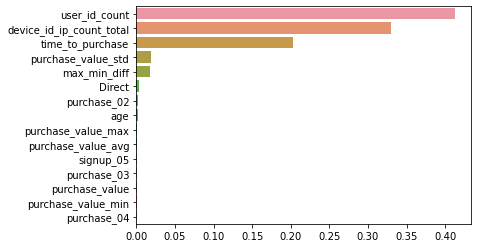

In [47]:
imp = pd.Series(rf_best.feature_importances_,
                index = X_train.columns)
top15 = imp.sort_values(ascending=False)[:15]

sns.barplot(x=top15, y=top15.index)
plt.show()

## GradientBoosting

In [25]:
gb = GradientBoostingClassifier()

param_grid = {
    'n_estimators': range(100, 500, 100),
    'max_depth': range(5, 15,5),
    'learning_rate': np.arange(0.01, 0.2, 0.02)
}
cv = RandomizedSearchCV(
    gb,
    param_grid,
    n_iter = 25,
    cv = 3,
    scoring='f1',
    random_state = random_state,
    verbose = 5
)
cv.fit(X_train_scaled, y_train)

gb_best = cv.best_estimator_

print('Gradient boosting CV score')
print(cross_val_score(gb_best, X_train_scaled, y_train, scoring='f1', cv=5))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 1/3] END learning_rate=0.18999999999999997, max_depth=5, n_estimators=400;, score=0.741 total time=  15.0s
[CV 2/3] END learning_rate=0.18999999999999997, max_depth=5, n_estimators=400;, score=0.727 total time=  14.7s
[CV 3/3] END learning_rate=0.18999999999999997, max_depth=5, n_estimators=400;, score=0.750 total time=  14.7s
[CV 1/3] END learning_rate=0.18999999999999997, max_depth=10, n_estimators=300;, score=0.740 total time=  24.6s
[CV 2/3] END learning_rate=0.18999999999999997, max_depth=10, n_estimators=300;, score=0.725 total time=  24.9s
[CV 3/3] END learning_rate=0.18999999999999997, max_depth=10, n_estimators=300;, score=0.739 total time=  25.0s
[CV 1/3] END learning_rate=0.049999999999999996, max_depth=5, n_estimators=300;, score=0.762 total time=  11.1s
[CV 2/3] END learning_rate=0.049999999999999996, max_depth=5, n_estimators=300;, score=0.743 total time=  11.0s
[CV 3/3] END learning_rate=0.04999999999999999

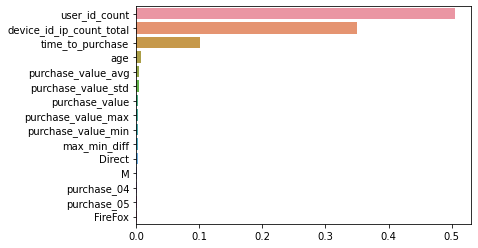

In [37]:
imp = pd.Series(gb_best.feature_importances_,
                index = X_train.columns)
top15 = imp.sort_values(ascending=False)[:15]

sns.barplot(x=top15, y=top15.index)
plt.show()

## logistic regression

In [30]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

print(lr.n_features_in_)
print(lr.coef_)

print('Logistic Regression CV score')
print(cross_val_score(lr, X_train_scaled, y_train, scoring='recall', cv=5))

C:\Users\jhoonpark\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jhoonpark\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

35
[[ 4.98406149e-02  4.30688835e-04 -7.59362294e-02  7.84897754e-02
   2.25969086e-01 -3.53240946e-01  7.18301190e-01 -3.57160009e-01
   1.07985717e+00  1.07985717e+00  7.75536197e-03  1.74613542e-02
  -4.84820577e-03  4.21703878e-03 -4.83332136e-02 -3.92465857e-02
  -3.30248811e-02 -4.98598847e-02 -2.83339906e-01 -3.48570148e-01
  -3.74827814e-01 -3.63504775e-01 -3.62552561e-01 -3.51247801e-01
  -3.49411685e-01 -2.98266521e-01 -2.30734272e-01 -1.41846866e-01
  -3.36258824e-02  8.25280224e-02  6.88855321e-03 -1.50176776e-02
  -8.36327694e-03  3.70593010e-03  9.72654822e-03]]
Logistic Regression CV score
[0.58444444 0.61722222 0.58532518 0.5975542  0.6131184 ]


C:\Users\jhoonpark\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## ensemble

In [41]:
vote = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('rf', rf_best),
        ('gb', gb_best)
    ],
    voting='soft'
)
vote.fit(X_train_scaled, y_train)

print('Voting classifier CV score')
print(cross_val_score(vote, X_train_scaled, y_train, scoring='recall', cv=5))

Voting classifier CV score
[0.64       0.67       0.63979989 0.64202335 0.66092273]


In [42]:
vote = VotingClassifier(
    estimators=[
        # ('lr', lr),
        ('rf', rf_best),
        ('gb', gb_best)
    ],
    voting='soft'
)
vote.fit(X_train_scaled, y_train)

print('Voting classifier CV score')
print(cross_val_score(vote, X_train_scaled, y_train, scoring='recall', cv=5))

Voting classifier CV score
[0.67777778 0.69388889 0.66759311 0.66592551 0.68315731]


## Best model
- Random Forest
    [0.7604134  0.76574924 0.75838295 0.77104691 0.7688958 ]
- Gradient Boosting
    [0.7606264  0.77308294 0.74665818 0.75056036 0.76202452]
- soft voting classifier
    [0.67777778 0.69388889 0.66759311 0.66592551 0.68315731]

> **RandomForest is the best model**

## Predict test case

In [198]:
test_case = pd.read_csv(directory + '/dataset/fraud_holdout_no_label.csv', index_col=0)
test_case.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address
6,159135,2015-05-21 6:03,2015-07-09 8:05,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09
7,50116,2015-08-01 22:40,2015-08-27 3:37,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09
10,182338,2015-01-25 17:49,2015-03-23 23:05,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08
11,199700,2015-07-11 18:26,2015-10-28 21:59,13,TEPSJVVXGNTYR,Ads,Safari,F,35,1.819009e+09
12,73884,2015-05-29 16:22,2015-06-16 5:45,58,ZTZZJUCRDOCJZ,Direct,Chrome,M,32,4.038285e+09


In [199]:
test_case.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31112 entries, 6 to 151105
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         31112 non-null  int64  
 1   signup_time     31112 non-null  object 
 2   purchase_time   31112 non-null  object 
 3   purchase_value  31112 non-null  int64  
 4   device_id       31112 non-null  object 
 5   source          31112 non-null  object 
 6   browser         31112 non-null  object 
 7   sex             31112 non-null  object 
 8   age             31112 non-null  int64  
 9   ip_address      31112 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 1.9+ MB


In [200]:
test_case['signup_time']      = test_case['signup_time'].astype(str)
test_case['signup_time_date'] = test_case['signup_time'].map(lambda x : datetime.strptime(x.split(' ')[0], '%Y-%m-%d'))
test_case['signup_time_date']

6        2015-05-21
7        2015-08-01
10       2015-01-25
11       2015-07-11
12       2015-05-29
            ...    
151090   2015-08-12
151094   2015-05-15
151097   2015-04-14
151100   2015-01-01
151105   2015-01-04
Name: signup_time_date, Length: 31112, dtype: datetime64[ns]

In [201]:
test_case['purchase_time']      = test_case['purchase_time'].astype(str)
test_case['purchase_time_date'] = test_case['purchase_time'].map(lambda x : datetime.strptime(x.split(' ')[0], '%Y-%m-%d'))
test_case['purchase_time_date']

6        2015-07-09
7        2015-08-27
10       2015-03-23
11       2015-10-28
12       2015-06-16
            ...    
151090   2015-12-03
151094   2015-07-08
151097   2015-06-24
151100   2015-01-01
151105   2015-01-04
Name: purchase_time_date, Length: 31112, dtype: datetime64[ns]

In [202]:
test_case['time_to_purchase'] = test_case['purchase_time_date'] - test_case['signup_time_date']
test_case['time_to_purchase'] = test_case['time_to_purchase']
test_case['time_to_purchase']

6         49 days
7         26 days
10        57 days
11       109 days
12        18 days
           ...   
151090   113 days
151094    54 days
151097    71 days
151100     0 days
151105     0 days
Name: time_to_purchase, Length: 31112, dtype: timedelta64[ns]

In [203]:
tmp_df_mean = pd.DataFrame(test_case.groupby('device_id')['purchase_value'].mean()).reset_index()
tmp_df_max  = pd.DataFrame(test_case.groupby('device_id')['purchase_value'].max()).reset_index()
tmp_df_min  = pd.DataFrame(test_case.groupby('device_id')['purchase_value'].min()).reset_index()
tmp_df_std  = pd.DataFrame(test_case.groupby('device_id')['purchase_value'].std()).reset_index().fillna(0)

tmp_df_purchase = pd.merge(tmp_df_max, tmp_df_min, on = 'device_id', how = 'left')
tmp_df_purchase.columns = ['device_id', 'purchase_value_max', 'purchase_value_min']

tmp_df_purchase = pd.merge(tmp_df_purchase, tmp_df_mean, on = 'device_id', how = 'left')
tmp_df_purchase.columns = ['device_id', 'purchase_value_max', 'purchase_value_min', 'purchase_value_mean']

tmp_df_purchase = pd.merge(tmp_df_purchase, tmp_df_std, on = 'device_id', how = 'left')
tmp_df_purchase.columns = ['device_id', 'purchase_value_max', 'purchase_value_min', 'purchase_value_mean', 'purchase_value_std']

tmp_df_purchase['max_min_diff'] = tmp_df_purchase['purchase_value_max'] - tmp_df_purchase['purchase_value_min']

tmp_df_purchase.columns = ['device_id', 'purchase_value_max', 'purchase_value_min', 'purchase_value_avg', 'purchase_value_std', 'max_min_diff']
tmp_df_purchase

,device_id,purchase_value_max,purchase_value_min,purchase_value_avg,purchase_value_std,max_min_diff
0,AAALBGNHHVMKG,45,45,45.0,0.0,0
1,AAAXXOZJRZRAO,57,57,57.0,0.0,0
2,AABGCAPIYUWNC,69,69,69.0,0.0,0
3,AACYYBUHPLDWT,62,62,62.0,0.0,0
4,AADGMPYOPXXCX,26,26,26.0,0.0,0
...,...,...,...,...,...,...
29832,ZZTJBZKBYQCCC,48,48,48.0,0.0,0
29833,ZZTUXVFOEHIJO,66,66,66.0,0.0,0
29834,ZZWJDOXKQKJPC,56,56,56.0,0.0,0
29835,ZZWYWEUXIOJOC,21,21,21.0,0.0,0


In [204]:
test_case = pd.merge(test_case, tmp_df_purchase, on='device_id', how='left')
test_case

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,signup_time_date,purchase_time_date,time_to_purchase,purchase_value_max,purchase_value_min,purchase_value_avg,purchase_value_std,max_min_diff
0,159135,2015-05-21 6:03,2015-07-09 8:05,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,2015-05-21,2015-07-09,49 days,42,42,42.0,0.0,0
1,50116,2015-08-01 22:40,2015-08-27 3:37,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,2015-08-01,2015-08-27,26 days,11,11,11.0,0.0,0
2,182338,2015-01-25 17:49,2015-03-23 23:05,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,2015-01-25,2015-03-23,57 days,62,62,62.0,0.0,0
3,199700,2015-07-11 18:26,2015-10-28 21:59,13,TEPSJVVXGNTYR,Ads,Safari,F,35,1.819009e+09,2015-07-11,2015-10-28,109 days,13,13,13.0,0.0,0
4,73884,2015-05-29 16:22,2015-06-16 5:45,58,ZTZZJUCRDOCJZ,Direct,Chrome,M,32,4.038285e+09,2015-05-29,2015-06-16,18 days,58,58,58.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31107,330979,2015-08-12 17:21,2015-12-03 0:00,43,WFYRTUQZQFSQJ,SEO,IE,M,34,1.966801e+09,2015-08-12,2015-12-03,113 days,43,43,43.0,0.0,0
31108,25306,2015-05-15 20:09,2015-07-08 14:21,38,GFIVGRRVFBFOF,SEO,Chrome,M,31,3.097327e+09,2015-05-15,2015-07-08,54 days,38,38,38.0,0.0,0
31109,27502,2015-04-14 23:43,2015-06-24 10:42,43,PYCNPZMYIETTA,Direct,Opera,F,30,4.202836e+09,2015-04-14,2015-06-24,71 days,43,43,43.0,0.0,0
31110,115473,2015-01-01 7:26,2015-01-01 7:26,61,ZRHCEVZHNIBJH,Direct,IE,M,24,3.003296e+09,2015-01-01,2015-01-01,0 days,61,61,61.0,0.0,0


In [205]:
tmp_df = pd.DataFrame(test_case.groupby(['device_id'])['user_id'].count()).reset_index()
tmp_df.columns = ['device_id', 'user_id_count']
tmp_df

,device_id,user_id_count
0,AAALBGNHHVMKG,1
1,AAAXXOZJRZRAO,3
2,AABGCAPIYUWNC,1
3,AACYYBUHPLDWT,1
4,AADGMPYOPXXCX,1
...,...,...
29832,ZZTJBZKBYQCCC,1
29833,ZZTUXVFOEHIJO,1
29834,ZZWJDOXKQKJPC,1
29835,ZZWYWEUXIOJOC,1


In [206]:
test_case = pd.merge(test_case, tmp_df, on='device_id', how='left')
test_case

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,signup_time_date,purchase_time_date,time_to_purchase,purchase_value_max,purchase_value_min,purchase_value_avg,purchase_value_std,max_min_diff,user_id_count
0,159135,2015-05-21 6:03,2015-07-09 8:05,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,2015-05-21,2015-07-09,49 days,42,42,42.0,0.0,0,1
1,50116,2015-08-01 22:40,2015-08-27 3:37,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,2015-08-01,2015-08-27,26 days,11,11,11.0,0.0,0,1
2,182338,2015-01-25 17:49,2015-03-23 23:05,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,2015-01-25,2015-03-23,57 days,62,62,62.0,0.0,0,1
3,199700,2015-07-11 18:26,2015-10-28 21:59,13,TEPSJVVXGNTYR,Ads,Safari,F,35,1.819009e+09,2015-07-11,2015-10-28,109 days,13,13,13.0,0.0,0,1
4,73884,2015-05-29 16:22,2015-06-16 5:45,58,ZTZZJUCRDOCJZ,Direct,Chrome,M,32,4.038285e+09,2015-05-29,2015-06-16,18 days,58,58,58.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31107,330979,2015-08-12 17:21,2015-12-03 0:00,43,WFYRTUQZQFSQJ,SEO,IE,M,34,1.966801e+09,2015-08-12,2015-12-03,113 days,43,43,43.0,0.0,0,1
31108,25306,2015-05-15 20:09,2015-07-08 14:21,38,GFIVGRRVFBFOF,SEO,Chrome,M,31,3.097327e+09,2015-05-15,2015-07-08,54 days,38,38,38.0,0.0,0,1
31109,27502,2015-04-14 23:43,2015-06-24 10:42,43,PYCNPZMYIETTA,Direct,Opera,F,30,4.202836e+09,2015-04-14,2015-06-24,71 days,43,43,43.0,0.0,0,1
31110,115473,2015-01-01 7:26,2015-01-01 7:26,61,ZRHCEVZHNIBJH,Direct,IE,M,24,3.003296e+09,2015-01-01,2015-01-01,0 days,61,61,61.0,0.0,0,4


In [207]:
tmp_df_ipaddress = pd.DataFrame(test_case.groupby(['device_id'])['ip_address'].count()).reset_index()
tmp_df_ipaddress.sort_values(by='ip_address', ascending=False, inplace = True)
tmp_df_ipaddress.columns = ['device_id', 'device_id_ip_count_total']
tmp_df_ipaddress

,device_id,device_id_ip_count_total
4575,EBIXBHKGUHCZE,8
20440,RWZCXZTQUORQL,8
16173,OFGKANFZLXBKH,7
3299,CXICHNYDPUZNN,7
26364,XAIIQCXNQBFHV,6
...,...,...
10053,IUYWADPYESOLZ,1
10052,IUYDVXGOFWHCH,1
10051,IUYCXLPYTJSXW,1
10050,IUXNAUVACYJOQ,1


In [208]:
test_case = pd.merge(test_case, tmp_df_ipaddress, on = 'device_id', how = 'left')

In [209]:
test_case.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address',
       'signup_time_date', 'purchase_time_date', 'time_to_purchase',
       'purchase_value_max', 'purchase_value_min', 'purchase_value_avg',
       'purchase_value_std', 'max_min_diff', 'user_id_count',
       'device_id_ip_count_total'],
      dtype='object')

In [210]:
test_case['purchase_month'] = test_case['purchase_time_date'].astype(str)
test_case['purchase_month'] = test_case['purchase_month'].map(lambda x : x.split('-')[1])
test_case['purchase_month']

0        07
1        08
2        03
3        10
4        06
         ..
31107    12
31108    07
31109    06
31110    01
31111    01
Name: purchase_month, Length: 31112, dtype: object

In [211]:
test_case['signup_month'] = test_case['signup_time_date'].astype(str)
test_case['signup_month'] = test_case['signup_month'].map(lambda x : x.split('-')[1])
test_case['signup_month']

0        05
1        08
2        01
3        07
4        05
         ..
31107    08
31108    05
31109    04
31110    01
31111    01
Name: signup_month, Length: 31112, dtype: object

In [212]:
gender_dummy         = pd.get_dummies(test_case.sex, drop_first = True)
signup_month_dummy   = pd.get_dummies(test_case.signup_month, drop_first = True, prefix = 'signup')
purchase_month_dummy = pd.get_dummies(test_case.purchase_month, drop_first = True, prefix = 'purchase')
source_dummy         = pd.get_dummies(test_case.source, drop_first = True)
browser_dummy        = pd.get_dummies(test_case.browser, drop_first = True)

test_case = test_case.drop(['sex','signup_month', 'purchase_month', 'source','browser'], axis=1)

final = pd.concat([test_case, gender_dummy, signup_month_dummy, purchase_month_dummy, source_dummy, browser_dummy], axis=1)
final.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,signup_time_date,purchase_time_date,time_to_purchase,...,purchase_09,purchase_10,purchase_11,purchase_12,Direct,SEO,FireFox,IE,Opera,Safari
0,159135,2015-05-21 6:03,2015-07-09 8:05,42,ALEYXFXINSXLZ,18,2.809315e+09,2015-05-21,2015-07-09,49 days,...,0,0,0,0,0,0,0,0,0,0
1,50116,2015-08-01 22:40,2015-08-27 3:37,11,IWKVZHJOCLPUR,19,3.987484e+09,2015-08-01,2015-08-27,26 days,...,0,0,0,0,0,0,0,0,0,0
2,182338,2015-01-25 17:49,2015-03-23 23:05,62,NRFFPPHZYFUVC,31,3.416747e+08,2015-01-25,2015-03-23,57 days,...,0,0,0,0,0,0,0,1,0,0
3,199700,2015-07-11 18:26,2015-10-28 21:59,13,TEPSJVVXGNTYR,35,1.819009e+09,2015-07-11,2015-10-28,109 days,...,0,1,0,0,0,0,0,0,0,1
4,73884,2015-05-29 16:22,2015-06-16 5:45,58,ZTZZJUCRDOCJZ,32,4.038285e+09,2015-05-29,2015-06-16,18 days,...,0,0,0,0,1,0,0,0,0,0


In [213]:
final = final.drop(['signup_time', 'purchase_time', 'device_id', 'ip_address', 'signup_time_date', 'purchase_time_date'], axis = 1)
final.columns

Index(['user_id', 'purchase_value', 'age', 'time_to_purchase',
       'purchase_value_max', 'purchase_value_min', 'purchase_value_avg',
       'purchase_value_std', 'max_min_diff', 'user_id_count',
       'device_id_ip_count_total', 'M', 'signup_02', 'signup_03', 'signup_04',
       'signup_05', 'signup_06', 'signup_07', 'signup_08', 'purchase_02',
       'purchase_03', 'purchase_04', 'purchase_05', 'purchase_06',
       'purchase_07', 'purchase_08', 'purchase_09', 'purchase_10',
       'purchase_11', 'purchase_12', 'Direct', 'SEO', 'FireFox', 'IE', 'Opera',
       'Safari'],
      dtype='object')

In [214]:
X = final.drop(['user_id'], axis=1)

In [215]:
X['time_to_purchase']

0        49 days
1        26 days
2        57 days
3       109 days
4        18 days
          ...   
31107   113 days
31108    54 days
31109    71 days
31110     0 days
31111     0 days
Name: time_to_purchase, Length: 31112, dtype: timedelta64[ns]

In [216]:
X['time_to_purchase'] = X['time_to_purchase'].dt.days.astype(int)

In [217]:
X_test_scaled = scaler.transform(X)

#### predict

In [218]:
pred = rf_best.predict(X_test_scaled)

In [219]:
test_case['predicted_value'] = pred.tolist()

In [221]:
test_case.to_csv('fraud_holdout_with_label.csv', index=False)

In [220]:
Counter(test_case['predicted_value'])

Counter({0: 29209, 1: 1903})